#### [詳解ディープラーニング　TensorFlow・Kerasによる時系列データ処理](https://book.mynavi.jp/ec/products/detail/id=72995)
　巣籠悠輔 著  
  
support site : [https://book.mynavi.jp/supportsite/detail/9784839962517.html](https://book.mynavi.jp/supportsite/detail/9784839962517.html)  
github : [yusugomori/deeplearning-tensorflow-keras](https://github.com/yusugomori/deeplearning-tensorflow-keras) 


---
## 第４章　ディープニューラルネットワーク

隠れ層を増やした"深い"ネットワークをディープニューラルネットワークと呼び、  
これを用いる学習を深層学習（deep learning）と呼ぶ。  
  
（注記：活性化関数がステップ関数である３層以下（隠れ層１層まで）の浅いネットワークをパーセプトロン、  
　シグモイド関数などを用い、多層化しているものをディープニューラルネットワークと  
　呼ぶ用法が多いように見受けられるが、厳密な定義を確認できなかったため  
　このnotebookでは書籍の記述に従う。）  

data shape is  (70000, 784)
target shape is  (70000,)
type of target is  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]


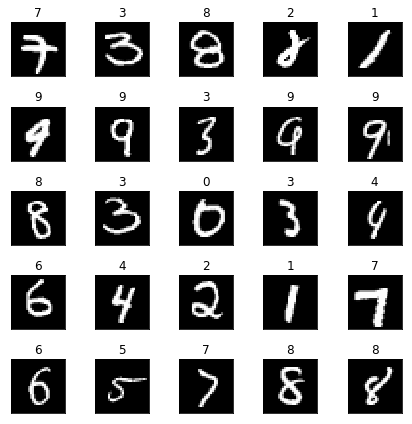

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home="./dataset")

def show_sample(n=25):
    p = np.random.randint(0,len(mnist.data), n)
    fig = plt.figure(figsize=(6,6))
    ax = {}
    for i in range(n):
        data, label = mnist.data[p[i]], mnist.target[p[i]]
        ax[i] = fig.add_subplot(int(np.sqrt(n)),int(np.sqrt(n)),i+1)
        ax[i].tick_params(labelbottom='off', bottom='off', labelleft='off', left='off')
        ax[i].imshow(data.reshape(28,28), cmap='gray')
        ax[i].set_title(int(label))
    plt.tight_layout()
    plt.show()

print("data shape is ", mnist.data.shape)
print("target shape is ", mnist.target.shape)
print("type of target is ", np.unique(mnist.target))
show_sample()

MNISTデータセットは上図の例のような手書き文字の画像データと、教師データとして数字を表すクラス番号を含む。  
隠れ層の深さやニューロン数と精度の関係をみるため、このデータセットを用いて以下の実験を行った。  

In [5]:
# データ抽出の例
import numpy as np
from sklearn.model_selection import train_test_split

indices = np.random.permutation(len(mnist.data))
X = mnist.data[indices]
Y = mnist.target[indices]
Y_onehot = np.eye(10)[Y.astype(int)]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_onehot, train_size=0.8, test_size=0.2)

隠れ層が１層のMLPでの例

In [46]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

indices = np.random.permutation(len(mnist.data))[:N]
X = mnist.data[indices]
Y = mnist.target[indices]
Y_onehot = np.eye(10)[Y.astype(int)]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_onehot, train_size=0.8, test_size=0.2)

n_in, n_hidden, n_out = X[0].shape[0], 200, Y_onehot[0].shape[0]

model = Sequential()
model.add(Dense(n_hidden, input_dim=n_in))
model.add(Activation('sigmoid'))
model.add(Dense(n_out))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=SGD(lr=0.01), 
              metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=1000, batch_size=100, verbose=0)
loss_and_metrics = model.evaluate(X_test, Y_test)
print(loss_and_metrics)

32/60 [===============>..............] - ETA: 0s[0.82040030558904009, 0.69999999602635699]


MLPの隠れ層のニューロン数を変えながら３回ずつ試験した結果は次の通りだった。  
値は小数点第３位で四捨五入した。  
  
| the number of neurons in hidden layer | mean accuracy (%) | measured accuracy values(%)
|--:|:-:|:-:|
|200|71.67| 68.33, 76.67, 70.00 |
|400|76.11| 68.33, 73.33, 86.67 |
|2000|79.44| 78.33, 75.00, 85.00 |
|4000|80.56| 86.67, 78.33, 76.67 |
|6000|76.11| 80.00, 68.33, 80.00 |


次にニューロン数を200に固定し、隠れ層を増やして各３回実験した。
具体的には、以下のコードを隠れ層として追加した。

~~~python
model.add(Activation('sigmoid'))
model.add(Dense(n_hidden))
~~~

結果は次の通り。

| the number of hidden layers | mean accuracy (%)| measured accuracy values (%) |
|--:|:-:|:-:|
| 1 | 72.22 | 71.67, 68.33, 76.67 |
| 2 | 66.67 | 56.67, 68.33, 75.00 |
| 3 | 51.67 | 50.00, 56.67, 48.33 |
| 4 | 18.33 | 21.67, 26.67, 6.67 |
| 5 | 11.11 | 11.67, 8.33, 13.33 |


単純な多層化やニューロン数の増加によっては性能改善はどこかのタイミングで頭打ちになることが知られており、  
その原因の１つは勾配消失問題である。  

---
### 勾配消失問題
M.Nielsenの表記に従い、第 $l$ 層 $j$ 番目のニューロンの誤差 $\delta^{l}_{j}$ を次のように定義する。  
ここで $C$ は誤差関数の値、$a^{l}_{j}$ は活性、$z^{l}_{j}$ はこのニューロンにおける活性化関数への重み付き入力である。     
  
\begin{align*}
\delta^{l}_{j} := \frac{\partial C}{\partial z^{l}_{j}}
\end{align*}

前回のノート(~_2.ipynb 参照)での議論から、誤差逆伝播法における各層の誤差は

\begin{align*}
\delta^{l} = ((w^{l+1})^{\mathrm{T}} \delta^{l+1}) \odot f^{\prime}(z^{l})
\end{align*}

であり、重みは

\begin{align*}
\frac{\partial C}{\partial w^{l}_{jk}} = a^{l-1}_{k} \delta^{l}_{j}
\end{align*}

すなわち

\begin{align*}
\frac{\partial C}{\partial w} = a_{in} \delta_{out}
\end{align*}

と書ける。  
  
さて、上の実験では活性化関数としてsigmoid関数を用いたが、その式と導関数は

\begin{align*}
\sigma(x) &= \frac{1}{1+\exp(-x)} \\
\sigma(x)^{\prime} &= \sigma(x)(1-\sigma(x))
\end{align*}

であり、そのグラフは下図のようになる。

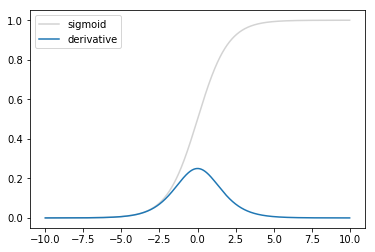

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from math import log

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x)*(1-sigmoid(x))

x = np.arange(-10,10,0.01)
#y = sigmoid(x)
#plt.figure(figsize=(4,3))
plt.plot(x,sigmoid(x), color='lightgray', label='sigmoid')
plt.plot(x,sigmoid_prime(x), label='derivative')
plt.legend()
plt.show() 

このようにsigmoid関数の導関数は値が小さく、$\sigma^{\prime}(x) \leq 0.25$ であるから、  
誤差を求める漸化式が $f^{\prime}(z^{l})$ の項を含むことより  
一層につき誤差の絶対値が0.25倍以下になることがわかる。  
この問題は、活性化関数へ入力する値の絶対値が大きいほど顕著である。  

これが勾配消失問題の要因の１つであり、  
微分が小さくない、誤差を減少させない活性化関数が求められることとなった。  
  
（ニューラルネットワークには勾配爆発問題もあり、これは誤差が逆伝播により急激に大きくなる問題である。  
　これらの根本は、前方の層の勾配がそれ以降の層の勾配の積となっているために  
　ニューラルネットワークが不安定勾配問題を伴っていることである。）    

---
### Overfitting

一般に過学習あるいは過剰適合と呼ばれる問題である。  
  
例として、 $f(x) = cos \left( \frac{3 \pi}{2}x \right)$ に従う分布から得られた30個のデータ $\{x_{i}\}$ があるとする。  
真の分布が未知であるとして、この分布を多項式関数  

\begin{align*}
\hat{f}(x) = a_{0} + a_{1}x + a_{2}x^{2} + \cdots + a_{n}x^{n} = \sum_{i=0}^{n}a_{i}x^{i}
\end{align*}

によって近似することを考える。  
  
下図は、それぞれ１次、４次、１６次、６４次の関数によって近似した結果の一例である。

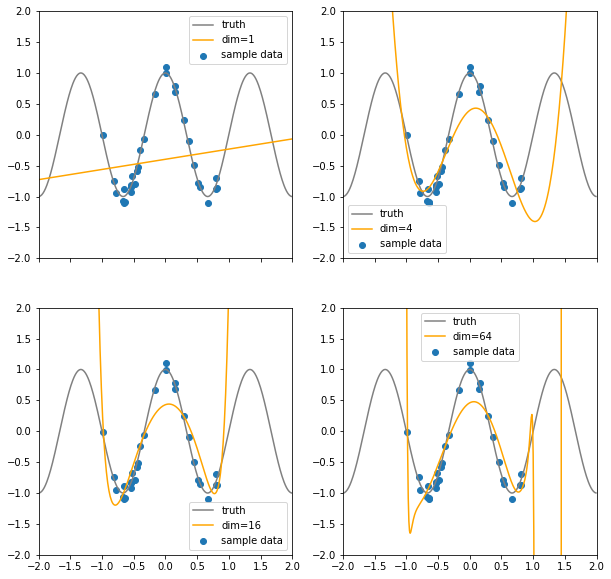

In [27]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

def target_f(x):
    return np.cos((3*np.pi*x)/2)

def aprox(X, Y, n, epochs=1000):
    Xe = np.array([[X[i]**j for j in range(n+1)] for i in range(X.shape[0])]).reshape(30,n+1)
    
    x = tf.placeholder(tf.float32, shape=[None, n+1])
    t = tf.placeholder(tf.float32, shape=[None, 1])
    
    W = tf.Variable(tf.truncated_normal([n+1,1]))
    y = tf.matmul(x,W)
    
    loss = tf.losses.mean_squared_error(t,y)
    train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    for epoch in range(epochs):
        X_, Y_ = shuffle(Xe, Y)
        sess.run(train_step, feed_dict={
            x: X_,
            t: Y_
        })
        
    return sess.run(W).reshape(n+1)

def predict(W,X):
    ya = []
    for x in X:
        yv = W * [x**j for j in range(len(W))]
        ya.append(np.sum(yv))
    return np.array(ya)

# dataset
#X = np.random.rand(30,1)
X = (np.random.rand(30,1)-0.5)*2
Y = np.cos((3*np.pi*X)/2) + (np.random.rand(30,1)-0.5)*0.3

W1 = aprox(X,Y,1)
W4 = aprox(X,Y,4)
W16 = aprox(X,Y,16)
W64 = aprox(X,Y,64)

# plot
xmin, xmax = -2,2
ymin, ymax = -2,2

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(10,10), sharex=True)
xline = np.arange(xmin, xmax, .01)

for ax, W, l in zip([ax1,ax2,ax3,ax4], [W1,W4,W16,W64], ['dim=1','dim=4','dim=16','dim=64']):
    ax.plot(xline, target_f(xline), color='gray', label='truth')
    ax.scatter(X,Y,label='sample data')
    ax.plot(xline, predict(W,xline), color='orange', label=l)
    ax.legend()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

plt.show()

上図に徴候が現れているが、近似式の次数が増加するに従い  
与えられたデータのみに過剰に適合する結果として真の分布から遠ざかる傾向がみられ、  
この状態を Overfitting という。  

---
### 学習の効率化

#### 活性化関数を変える
　・実用上はReLUで十分のようだ。  
  
参考：  
　[CS231n, Neural Networks Part 1: Setting up the Architecture](http://cs231n.github.io/neural-networks-1/)  
　[Visualising Activation Functions in Neural Networks](https://dashee87.github.io/data%20science/deep%20learning/visualising-activation-functions-in-neural-networks/) <- グラフと定義付き。こちらを見るほうが早いです    
  
$\,$  
  
・双曲線正接関数 (hyperbolic tangent function)  

\begin{align*}
\tanh(x) &= \frac{\sinh(x)}{\cosh(x)} = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}} &  \sinh(x)=\frac{e^{x}-e^{-x}}{2}, \cosh(x)=\frac{e^{x}+e^{-x}}{2}\\
(\tanh(x))^{\prime} &= \frac{1}{\cosh^{2}(x)} = \frac{4}{(e^{x} + e^{-x})^{2}}
\end{align*}

・ReLU (rectified linear unit)

\begin{align*}
relu(x) &= max(0,x) \\
(relu(x))^{\prime} &= \begin{cases} 1 & (x > 0 ) \\ 0 & (x \leq 0 ) \end{cases}
\end{align*}

・Leaky ReLU  
　$\,$　一般に $\alpha$ は１より小さく、$\alpha=0.01$ などがよく使われる。
 
\begin{align*}
lrelu(x) &= max(\alpha x , x) \\
(lrelu(x))^{\prime} &= \begin{cases} 1 & (x > 0) \\ \alpha & (x \leq 0) \end{cases}
\end{align*}

・SeLU  
　$\,$　パラメータの提案値は $ \lambda $ = 1.0507009873554804934193349852946, $ \alpha $ = 1.6732632423543772848170429916717
 
\begin{align*}
selu(x) &= \lambda \begin{cases} x & (x > 0) \\ \alpha e^{x} - \alpha & (x \leq 0) \end{cases} \\
(selu(x))^{\prime} &= \begin{cases} \lambda & (x > 0) \\ \lambda \alpha e^{x} = \lambda( selu(x) + \alpha) & (x \leq 0) \end{cases}
\end{align*}

・Swish  
　$\,$　(以下　$sigmoid(x) = \sigma (x) $ とする)

\begin{align*}
swish(x) &= x \sigma(\beta x) \\
(swish(x))^{\prime} &= \sigma(\beta x) + \beta x \cdot \sigma(\beta x)(1- \sigma(\beta x)) \\
&= \beta x \sigma(x) + \sigma(\beta x)(1- \beta x \sigma(\beta x)) \\
&= \beta \cdot swish(x) + \sigma(\beta x)(1 - \beta \cdot swish(x))
\end{align*}

以下に関数とその導関数の概形を示す。ただしパラメータは代表的な値に固定している。

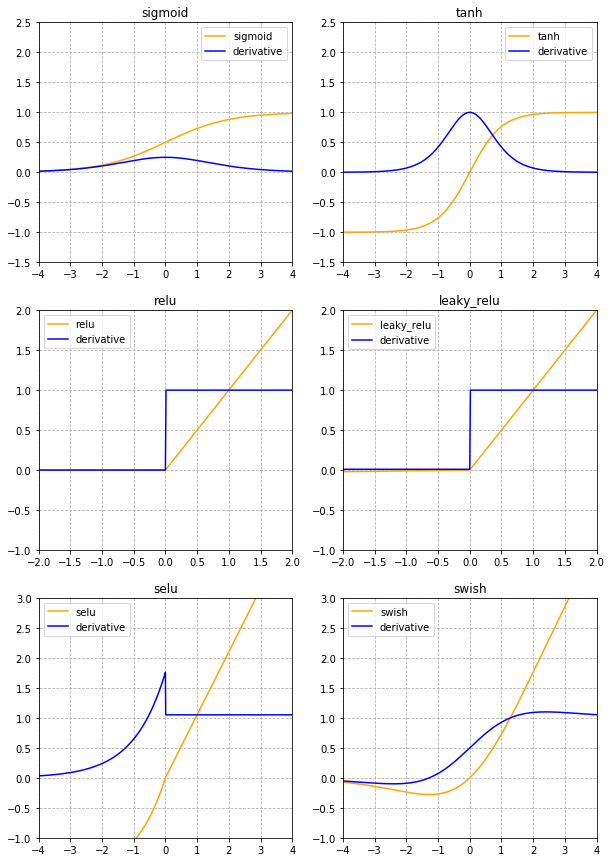

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+ np.exp(-x))
def dsigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))
    
def tanh(x):
    return np.tanh(x)
def dtanh(x):
    return 4/((np.exp(x) + np.exp(-x))**2)
    
def relu(x):
    return max(0,x)
def drelu(x):
    return 1 if x>0 else 0

def leaky_relu(x, alpha=0.01):
    return max(alpha*x, x)
def dleaky_relu(x, alpha=0.01):
    return 1 if x>0 else alpha

def selu(x, scale=1.0507009873554804934193349852946, alpha=1.6732632423543772848170429916717):
    return scale*x if x>0 else alpha*(np.exp(x)-1)
def dselu(x, scale=1.0507009873554804934193349852946, alpha=1.6732632423543772848170429916717):
    return scale if x>0 else scale*alpha*np.exp(x)

def swish(x,beta=1):
    return x/(1 + np.exp(-x * beta))
def dswish(x,beta=1):
    return 1/(1 + np.exp(-x * beta)) + (beta*x)/(1 + np.exp(-x * beta)) * (1-(1/(1 + np.exp(-x * beta))))
    # return beta*swish(x) + sigmoid(beta*x) * (1 - beta * swish(x))


# functions[n] = [function, its derivative, plotting_parameter=[xmin, xmax, ymin, ymax]]
functions = [[sigmoid, dsigmoid, [-4, 4, -1.5, 2.5]],
             [tanh, dtanh, [-4, 4, -1.5, 2.5]],
             [relu, drelu, [-2, 2, -1, 2]],
             [leaky_relu, dleaky_relu, [-2, 2, -1, 2]],
             [selu, dselu, [-4, 4, -1, 3]],
             [swish, dswish, [-4, 4, -1, 3]]
            ]
xline = np.arange(-4, 4, .01)

# plot
fig, ax = plt.subplots(np.ceil(len(functions)/2).astype(int), 2, 
                       figsize=(10,5*np.ceil(len(functions)/2).astype(int)))


for axn, [f, df,lim] in zip(ax.reshape(-1),functions):
    axn.plot(xline, list(map(f,xline)), color='orange', label=f.__name__)
    axn.plot(xline, list(map(df,xline)), color='blue', label='derivative')
    axn.set_title(f.__name__)
    axn.legend()
    axn.set_xlim(lim[0],lim[1])
    axn.set_ylim(lim[2],lim[3])
    axn.grid(linestyle='dashed')
    
plt.show()

---
#### 実装例
代表的な活性化関数はフレームワークに組み込まれていることが多いが、ここでは別途実装を行う。  
tensorflow内のbuild-in関数を組み合わせるのが簡単そうである。  
完全に１から組むこともできるようだが、要 c++ とのこと。  
　-> [TensorFlow Official site : Extend - Adding a New Op](https://www.tensorflow.org/extend/adding_an_op#adding-a-new-op)  



#### 例１（書籍掲載のもの）  
　Parametric ReLUを実装する。この関数は学習可能なパラメータ $\alpha$ を持ち、定義は次の通り。  
　ここで入力 $x = \{x_{i}\}$ 、パラメータ $\alpha = \{\alpha_{i}\}$ はサイズが等しいベクトル、Cは誤差関数とする。  
 
\begin{align*}
prelu(x_{i}) &= \begin{cases} x_{i} & (x_{i}>0) \\ \alpha_{i} x_{i} & (x_{i} \leq 0) \end{cases} \\
&= \max(0, x_{i}) + \alpha_{i}\ min (0, x_{i}) \\
\\
\frac{\partial C}{\partial \alpha_{i}} &= \sum_{x_{i}} \frac{\partial C}{\partial \, prelu(x_{i})} \frac{\partial \, prelu(x_{i})}{\partial \alpha_{i}} \\
\frac{\partial \, prelu(x_{i})}{\partial \alpha_{i}} &= \begin{cases}0 & (x>0) \\ x_{i} & (x_{i} \leq 0) \end{cases}
\end{align*}

In [21]:
# tensorflowでのprelu()の実装
def prelu(x, alpha):
    return tf.maximum(tf.zeros(tf.shape(x)),x) + alpha * tf.minimum(tf.zeros(tf.shape(x)),x)

# usage, put them in model-definition block
W = tf.Variable(tf.truncated_normal([n_in, n_hidden], stddev=0.01))
b = tf.ariable(tf.zeros([n_hidden]))
alpha = tf.Variable(tf.zeros([n_hidden]))
h  =　prelu(tf.matmul(x,W) + b, alpha)

In [ ]:
# Keras has PReLU layer in layers.adbanced_activations
from keras.layers.advanced_activations import PReLU

model.add(PReLU())

#### 例２  
　参考：[stackoverflow - How to make a custom activation function with only Python in Tensorflow?](https://stackoverflow.com/questions/39921607/how-to-make-a-custom-activation-function-with-only-python-in-tensorflow)  
  
入力xの少数部分rが0.5以下の時にrを、それ以外で0を返す関数spiky(x)を実装したいとする。   

In [ ]:
def spiky(x):
    r = tf.floormod(x, tf.constant(1))
    cond = tf.less_equal(r, tf.constant(0.5))
    return tf.where(cond, r, tf.constant(0))

---
Kerasで書くにはバックエンドを使用する。これは低水準の操作を行うために用意された機能で、  
TensorFlow, Theano, CNTKのうち現在設定されているバックエンドで指定された操作を実施する。  

参考：  
　Keras Documentation : [Keras backends](https://keras.io/backend/#switching-from-one-backend-to-another)  
　backendの実装 : [github, fchollet/keras/keras/backend/tensorflow_backend.py](https://github.com/fchollet/keras/blob/master/keras/backend/tensorflow_backend.py)  
  
TensorFlowとKerasの記述を混ぜることも可能なようだ。  
　[Keras as a simplified interface to TensorFlow: tutorial | The Keras Blog](https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html)    

#### 例３　Kerasで書く  
  
　参考：[stackoverflow : How do you create a cusom activation function with Keras?](https://stackoverflow.com/questions/43915482/how-do-you-create-a-custom-activation-function-with-keras)  
　original? : [How do you create custom activation? I got an error. #4076](https://github.com/fchollet/keras/issues/4076#issue-183230193)  on github - fchollet/keras  

In [ ]:
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

def custom_activation(x):
    return (K.sigmoid(x) * 5) - 1

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

model.add(Activation(custom_activation))

Keras documentationの[utilsの項](https://keras.io/ja/utils/)を読む限り、  
get_custom_objectsよりもcustom_object_scopeを使ったほうが良さそう

In [ ]:
# usage example
with custom_object_scope({'MyObject':MyObject}):
    layer = Dense(..., kernel_regularizer='MyObject')
    # save, load, etc. will recognize custom object by name

---
#### 比較実験
活性化関数の比較を以下のように行った。  
  
条件：  
　隠れ層４層、ニューロン数200/layer、SGDによる学習（学習率0.01）で  
　MNISTからランダムに抽出した10000枚のうち8割で学習を行い、  
　残り2割でテストを行ってクラス分類のaccuracyを比較する。  
　epoch数は50、各３回行ってaccuracyの平均値を求める。  
　  
　実験ごとにデータとモデルは再生成し、乱数のre-seedを行う。    

---
実験時メモ：  
・70000枚フルに使用するとsigmoidでもaccuracyが0.9程度まで上がる  
  
・乱数のseedを書籍と変えると、lossの値がnanになり学習が止まる問題が多発した。  
　Kerasのcategorical_crossentropyの定義は次の通りで  
 
~~~python
from . import backend as K

def categorical_crossentropy(y_true, y_pred):
    return K.categorical_crossentropy(y_true, y_pred)
~~~

　backend/tensorflow_backend.pyでの定義は次の通り。
 
~~~python
def categorical_crossentropy(target, output, from_logits=False):
    """Categorical crossentropy between an output tensor and a target tensor.
    # Arguments
        target: A tensor of the same shape as `output`.
        output: A tensor resulting from a softmax
            (unless `from_logits` is True, in which
            case `output` is expected to be the logits).
        from_logits: Boolean, whether `output` is the
            result of a softmax, or is a tensor of logits.
    # Returns
        Output tensor.
    """
    # Note: tf.nn.softmax_cross_entropy_with_logits
    # expects logits, Keras expects probabilities.
    if not from_logits:
        # scale preds so that the class probas of each sample sum to 1
        output /= tf.reduce_sum(output,
                                axis=len(output.get_shape()) - 1,
                                keep_dims=True)
        # manual computation of crossentropy
        _epsilon = _to_tensor(epsilon(), output.dtype.base_dtype)
        output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
        return - tf.reduce_sum(target * tf.log(output),
                               axis=len(output.get_shape()) - 1)
    else:
        return tf.nn.softmax_cross_entropy_with_logits(labels=target,
                                                       logits=output)
~~~

誤差関数として交差エントロピーを用いるとき、

\begin{align*}
\lim_{x \rightarrow +0}(log(x) ) \rightarrow -\infty
\end{align*}

であるから、outputの値が０に近づくとき tf.reduce_sum(target * tf.log(output)) の値はNaNとなる。  
  
自作関数でこれを解決する方法の例としては  
　（出展：斎藤康毅(2016) 『ゼロから作るDeep Learning』 O'REILLY Japan, pp.89-91）  

~~~python
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))
~~~

のように、入力に極小値を加える手法がある。  
今回はこの手法を適用し、以下のように交差エントロピー関数を書き換えたものを使用した。  

In [93]:
import tensorflow as tf
from keras.backend.tensorflow_backend import _to_tensor
from keras.backend.common import epsilon

def custom_categorical_crossentropy(target, output, from_logits=False, delta=1e-7):
    if not from_logits:
        output /= tf.reduce_sum(output,
                                axis=len(output.get_shape()) - 1,
                                keep_dims=True)
        _epsilon = _to_tensor(epsilon(), output.dtype.base_dtype)
        output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
        return - tf.reduce_sum(target * tf.log(output + delta),
                               axis=len(output.get_shape()) - 1)
    else:
        return tf.nn.softmax_cross_entropy_with_logits(labels=target,
                                                       logits=output)

kerasに組み込まれていない活性化関数のコードについては次の通り。

In [117]:
from keras import backend as K
def swish(x):
    return x * K.sigmoid(x)

---
実験で使用したコードと結果は以下の通り。  

In [118]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

from keras.utils.generic_utils import CustomObjectScope
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

def exam_activation_f(activation_function_name, 
                      epochs=50, batch_size=200, verbose=1,
                      random_seed=None, data_size=10000):
    # for using same seed as the book, set random_seed=1234

    # initialize random seed
    np.random.seed(random_seed)

    # dataset
    mnist = fetch_mldata('MNIST original', data_home="./dataset")
    indices = np.random.permutation(len(mnist.data))[:data_size]
    X = mnist.data[indices]
    Y = mnist.target[indices]
    Y_onehot = np.eye(10)[Y.astype(int)]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y_onehot, train_size=0.8, test_size=0.2)

    # model definition
    n_in, n_hidden, n_out = X[0].shape[0], 200, Y_onehot[0].shape[0]

    with CustomObjectScope({'custom_categorical_crossentropy':custom_categorical_crossentropy,
                            'swish':swish
                           }):
        model = Sequential()
        model.add(Dense(n_hidden, input_dim=n_in))
        model.add(Activation(activation_function_name))
        model.add(Dense(n_hidden))
        model.add(Activation(activation_function_name))
        model.add(Dense(n_hidden))
        model.add(Activation(activation_function_name))
        model.add(Dense(n_hidden))
        model.add(Activation(activation_function_name))
        model.add(Dense(n_out))
        model.add(Activation('softmax'))

        model.compile(loss='custom_categorical_crossentropy', 
#        model.compile(loss='categorical_crossentropy', 
                      optimizer=SGD(lr=0.01), 
                      metrics=['accuracy'])

        history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
        loss_and_metrics = model.evaluate(X_test, Y_test)
        print(loss_and_metrics)

        return history

In [127]:
# exam
activation_function_list = ['linear', 'sigmoid', 'tanh', 'relu', 'selu', 'swish']
test_per_af = 5

master_records = {}

for name in activation_function_list:
    print("Activation function = {}".format(name))
    records = []
    for i in range(test_per_af):
        history = exam_activation_f(name, verbose=0, random_seed=None)
        records.append(history)
    master_records[name]=records
    print(" --- ")

Activation function = linear
1280/2000 [==================>...........] - ETA: 0s [12.494328857421875, 0.1895]
 --- 
Activation function = sigmoid
1152/2000 [================>.............] - ETA: 0s [2.2754129447937013, 0.1125]
 --- 
Activation function = tanh
1120/2000 [===============>..............] - ETA: 0s [0.29231842726469037, 0.91300000000000003]
 --- 
Activation function = relu
1120/2000 [===============>..............] - ETA: 0s [0.51277515406196472, 0.92500000000000004]
 --- 
Activation function = selu
1888/2000 [===========================>..] - ETA: 0s[0.6479390716716662, 0.94799999999999995]
 --- 
Activation function = swish
 928/2000 [============>.................] - ETA: 0s [13.990428482055664, 0.092999999999999999]
 --- 


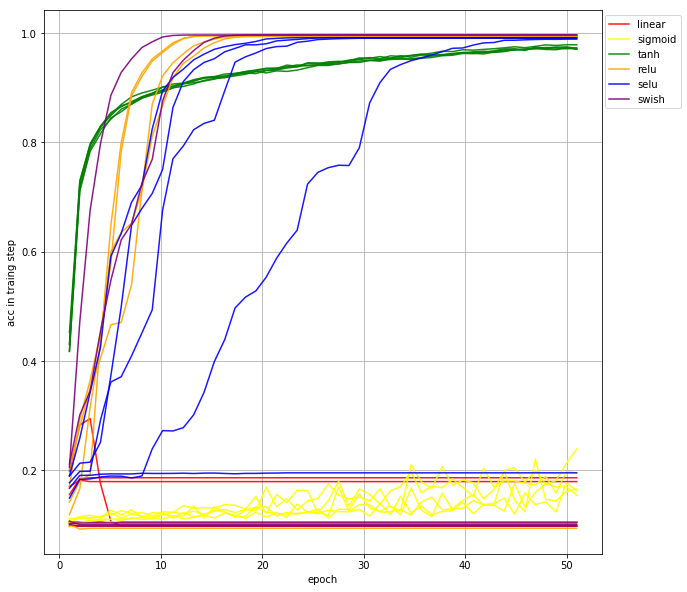

In [168]:
import matplotlib.pyplot as plt

colors = ['red', 'yellow', 'green', 'orange', 'blue', 'purple']

plt.figure(figsize=(10,10))
xline = np.linspace(1,len(master_records[activation_function_list[0]][0].history['acc'])+1)

for i, (key, value) in enumerate(master_records.items()):
    for j, v in enumerate(value):
        plt.plot(xline, np.array(v.history['acc']), 
                 color=colors[i], label=key if j==0 else None, alpha=0.9)

plt.xlabel("epoch")
plt.ylabel('acc in traing step')
plt.grid()
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 0.9, 0.1, 0.1))
plt.show()

| activation function | mean accuracy (%) |
|--:|:-:|
| Linear | 13.36 |
| Sigmoid | 12.29 |
| Tanh | 91.75 |
| ReLU | 76.05 |
| SeLU | 78.91 |
| Swish | 42.82 |


---
#### 考察
　今回の実験では学習失敗例が多発しており、乱数のseed値への鋭敏性も高く、  
　５回の試行で統計的な妥当性を得るのは難しい。  
  
　恒等関数やシグモイド関数ではほとんど学習できていないが  
　それ以外の活性化関数では学習成功時に９割を超えるAccuracyが得られており、  
　現在頻用される活性化関数が不安定勾配問題を改善していることが推察された。  
   
　正則化やドロップアウト等を導入したモデルの結果と比較を行いたい。  

---
### Dropout

Overfittingなどの問題のため、深層学習では訓練データに対して予測精度を向上させたとしても  
評価データや実運用時の予測精度が上がるとは限らない。  
  
訓練データに含まれない未知のデータに対して予測精度を上昇させるように学習することを汎化（generalization）、  
また未知データに対しての予測性能を汎化性能（generalization ability）という。  
  
汎化のための手法はいくつも存在し、その一つがドロップアウト（dropout）である。    
これは学習時にランダムにニューロンをdropoutさせて出力を０にする手法で、  
擬似的なアンサンブル学習（個別に学習させた複数の識別器の出力から予測を作る）とみなすことができる。  
  
ドロップアウトの実装では対象の層と同じshapeを持つarrayであるマスクベクトル $m$ を用意し、  
学習時には出力との要素積をとり、出力時にはoff（or 全て１）とする。  

式で表すと、あるネットワークの入力 $x$ に対する出力 $h_{i}$ が  
  
\begin{align*}
h_{i} = f(Wx + b)
\end{align*}
  
と表されるとき、これを  

\begin{align*}
h_{i} = f(Wx + b) \odot m
\end{align*}

へと変更する。

このとき続く層の出力 $ h_{i+1}$ を

\begin{align*}
h_{i+1} = g(Vh_{i} + c)
\end{align*}

また、それぞれの層で活性化関数に代入される重み付き和を

\begin{align*}
p := Wx + b \\
q := Vh_{i} + c
\end{align*}

とするとき、誤差項 $ \delta_{hi}, \delta_{hi+1} $ は、

\begin{align*}
\delta_{hi} &:= \frac{\partial E_{n}}{\partial p} \\
\delta_{hi+1} &:= \frac{\partial E_{n}}{\partial q}
\end{align*}

より

\begin{align*}
\delta_{hi} &= \frac{\partial E_{n}}{\partial q}\frac{\partial q}{\partial p} \\
&= \frac{\partial E_{n}}{\partial q}\frac{\partial}{\partial p}(Vf(p) \odot m + c) \\
&= f^{\prime}(p) \odot m \odot V^{\mathrm{T}}\delta_{hi+1}
\end{align*}

となる。

---
#### Tensorflowでの実装例

In [27]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

class toy_test_tf_mnist(object):
    def __init__(self, data_size=10000, n_hidden_layer = 3, n_hidden_cell=200, 
                 train_size=0.8, test_size=0.2, learning_rate=0.01, np_seed=None):
        self.data_size = data_size
        self.n_hidden_layer = max(n_hidden_layer, 1)
        self.n_hidden_cell = max(n_hidden_cell, 1)
        self.train_size = train_size
        self.test_size = test_size
        self.lr = learning_rate
        self.np_seed = np_seed
        
    def set_each_dataset(self):
        mnist = fetch_mldata('MNIST original', data_home="./dataset")
        indices = np.random.permutation(len(mnist.data))[:self.data_size]
        self.X = mnist.data[indices]
        self.Y = mnist.target[indices]
        self.Y_onehot = np.eye(10)[self.Y.astype(int)]
        self.X_train, self.X_test, self.Y_train, self.Y_test = \
            train_test_split(self.X, self.Y_onehot, train_size=self.train_size, test_size=self.test_size)
        self.n_in, self.n_out = self.X_train[0].shape[0], self.Y_train[0].shape[0]

    def generate_model(self):
        self.x = tf.placeholder(tf.float32, shape=[None, self.n_in])
        self.t = tf.placeholder(tf.float32, shape=[None, self.n_out])
        self.keep_prob = tf.placeholder(tf.float32)
        
        self.W = {}
        self.b = {}
        self.h = {}
        self.h_drop = {}
        
        # input layer - hidden layer 1
        self.W[0] = tf.Variable(tf.truncated_normal([self.n_in, self.n_hidden_cell], stddev=0.01))
        self.b[0] = tf.Variable(tf.zeros([self.n_hidden_cell]))
        self.h[0] = tf.nn.relu(tf.matmul(self.x, self.W[0]) + self.b[0])
        self.h_drop[0] = tf.nn.dropout(self.h[0], self.keep_prob)

        for i in range(self.n_hidden_layer - 1):
            self.W[i+1] = tf.Variable(tf.truncated_normal([self.n_hidden_cell, self.n_hidden_cell], stddev=0.01))
            self.b[i+1] = tf.Variable(tf.zeros([self.n_hidden_cell]))
            self.h[i+1] = tf.nn.relu(tf.matmul(self.h[i], self.W[i+1]) + self.b[i+1])
            self.h_drop[i+1] = tf.nn.dropout(self.h[i+1], self.keep_prob)

        # hidden layer - output layer
        self.W[self.n_hidden_layer] = tf.Variable(tf.truncated_normal([self.n_hidden_cell, self.n_out], stddev=0.01))
        self.b[self.n_hidden_layer] = tf.Variable(tf.zeros([self.n_out]))
        self.y = tf.nn.softmax(tf.matmul(self.h_drop[self.n_hidden_layer-1], self.W[self.n_hidden_layer]) + self.b[self.n_hidden_layer])

        self.cross_entropy = tf.reduce_mean(-tf.reduce_sum(self.t * tf.log(self.y), reduction_indices=[1]))
        self.train_step = tf.train.GradientDescentOptimizer(self.lr).minimize(self.cross_entropy)
        
        self.correct_prediction = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.t, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction , tf.float32))
        
    def fit(self, epochs=30, batch_size=200):
        init = tf.global_variables_initializer()
        sess = tf.Session()
        sess.run(init)
        
        n_batches = int(self.data_size * self.train_size) // batch_size
        
        for epoch in range(epochs):
            X_, Y_ = shuffle(self.X_train, self.Y_train)
            
            for i in range(n_batches):
                start = i * batch_size
                end = start + batch_size
            
                sess.run(self.train_step, feed_dict={
                    self.x: X_[start:end],
                    self.t: Y_[start:end],
                    self.keep_prob:0.5
                })
                
            loss = self.cross_entropy.eval(session=sess, feed_dict={
                self.x: X_,
                self.t: Y_,
                self.keep_prob: 1.0
            })
            acc = self.accuracy.eval(session=sess, feed_dict={
                self.x: X_,
                self.t: Y_,
                self.keep_prob: 1.0
            })
            print('epoch:', epoch, ' loss:', loss, ' accuracy:', acc)
                
        accuracy_rate = self.accuracy.eval(session=sess, feed_dict={
            self.x: X_test,
            self.t: Y_test,
            self.keep_prob: 1.0
        })
        print('accuracy: ', accuracy_rate)

    def predict(self):
        pass


In [28]:
testenv = toy_test_tf_mnist(data_size=10000, n_hidden_layer=3, n_hidden_cell=200, 
                 train_size=0.8, test_size=0.2, learning_rate=0.01, np_seed=None)
testenv.set_each_dataset()
testenv.generate_model()
testenv.fit(epochs=30, batch_size=200)

epoch: 0  loss: 2.21847  accuracy: 0.355
epoch: 1  loss: 1.34172  accuracy: 0.518875
epoch: 2  loss: 0.68848  accuracy: 0.795375
epoch: 3  loss: 0.510784  accuracy: 0.85475
epoch: 4  loss: 0.423561  accuracy: 0.877875
epoch: 5  loss: 0.406976  accuracy: 0.879
epoch: 6  loss: 0.338044  accuracy: 0.90175
epoch: 7  loss: 0.275091  accuracy: 0.920875
epoch: 8  loss: 0.252884  accuracy: 0.927875
epoch: 9  loss: 0.223942  accuracy: 0.9385
epoch: 10  loss: 0.199813  accuracy: 0.946625
epoch: 11  loss: 0.183947  accuracy: 0.951625
epoch: 12  loss: 0.213043  accuracy: 0.93775
epoch: 13  loss: 0.16217  accuracy: 0.95425
epoch: 14  loss: 0.137895  accuracy: 0.963375
epoch: 15  loss: 0.13419  accuracy: 0.961375
epoch: 16  loss: 0.113877  accuracy: 0.969
epoch: 17  loss: 0.114468  accuracy: 0.96975
epoch: 18  loss: 0.100676  accuracy: 0.9715
epoch: 19  loss: 0.102155  accuracy: 0.969875
epoch: 20  loss: 0.0779099  accuracy: 0.98075
epoch: 21  loss: 0.0769341  accuracy: 0.979375
epoch: 22  loss: 0.0

In [32]:
# use double size of data
testenv_2 = toy_test_tf_mnist(data_size=20000, n_hidden_layer=3, n_hidden_cell=200, 
                 train_size=0.8, test_size=0.2, learning_rate=0.01, np_seed=None)
testenv_2.set_each_dataset()
testenv_2.generate_model()
testenv_2.fit(epochs=30, batch_size=200)

epoch: 0  loss: 1.59365  accuracy: 0.586125
epoch: 1  loss: 0.551976  accuracy: 0.8265
epoch: 2  loss: 0.407156  accuracy: 0.880875
epoch: 3  loss: 0.311259  accuracy: 0.906313
epoch: 4  loss: 0.265456  accuracy: 0.918562
epoch: 5  loss: 0.227006  accuracy: 0.932312
epoch: 6  loss: 0.179275  accuracy: 0.94725
epoch: 7  loss: 0.164136  accuracy: 0.951437
epoch: 8  loss: 0.130982  accuracy: 0.960688
epoch: 9  loss: 0.112578  accuracy: 0.966625
epoch: 10  loss: 0.0981089  accuracy: 0.971438
epoch: 11  loss: 0.0889126  accuracy: 0.973562
epoch: 12  loss: 0.0830191  accuracy: 0.975375
epoch: 13  loss: 0.0682038  accuracy: 0.980313
epoch: 14  loss: 0.0650561  accuracy: 0.981375
epoch: 15  loss: 0.0515778  accuracy: 0.986125
epoch: 16  loss: 0.0465563  accuracy: 0.986875
epoch: 17  loss: 0.0458186  accuracy: 0.987938
epoch: 18  loss: 0.0377791  accuracy: 0.990562
epoch: 19  loss: 0.0363825  accuracy: 0.990625
epoch: 20  loss: 0.0281422  accuracy: 0.993375
epoch: 21  loss: 0.0277785  accuracy:

---
#### Kerasでの実装例

In [5]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

from keras.utils.generic_utils import CustomObjectScope
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from keras.backend.tensorflow_backend import _to_tensor
from keras.backend.common import epsilon

def custom_categorical_crossentropy(target, output, from_logits=False, delta=1e-7):
    if not from_logits:
        output /= tf.reduce_sum(output,
                                axis=len(output.get_shape()) - 1,
                                keep_dims=True)
        _epsilon = _to_tensor(epsilon(), output.dtype.base_dtype)
        output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
        return - tf.reduce_sum(target * tf.log(output + delta),
                               axis=len(output.get_shape()) - 1)
    else:
        return tf.nn.softmax_cross_entropy_with_logits(labels=target,
                                                       logits=output)


class toy_test_keras_mnist(object):
    def __init__(self, data_size=10000, n_hidden_layer = 3, n_hidden_cell=200, 
                 train_size=0.8, test_size=0.2, learning_rate=0.01, keep_prob=0.5, np_seed=None):
        self.data_size = data_size
        self.n_hidden_layer = max(n_hidden_layer, 1)
        self.n_hidden_cell = max(n_hidden_cell, 1)
        self.train_size = train_size
        self.test_size = test_size
        self.lr = learning_rate
        self.keep_prob = keep_prob
        self.np_seed = np_seed
        
    def set_each_dataset(self):
        mnist = fetch_mldata('MNIST original', data_home="./dataset")
        indices = np.random.permutation(len(mnist.data))[:self.data_size]
        self.X = mnist.data[indices]
        self.Y = mnist.target[indices]
        self.Y_onehot = np.eye(10)[self.Y.astype(int)]
        self.X_train, self.X_test, self.Y_train, self.Y_test = \
            train_test_split(self.X, self.Y_onehot, train_size=self.train_size, test_size=self.test_size)
        self.n_in, self.n_out = self.X_train[0].shape[0], self.Y_train[0].shape[0]
        print("n_in={}, n_out={}".format(self.n_in, self.n_out))

    def fit(self, epochs=150, batch_size=200, activation_function='tanh', loss_function='categorical_crossentropy'):
        with CustomObjectScope({'custom_categorical_crossentropy':custom_categorical_crossentropy}):
            self.model = Sequential()

            self.model.add(Dense(self.n_hidden_cell, input_dim=self.n_in))
            self.model.add(Activation(activation_function))
            self.model.add(Dropout(self.keep_prob))

            for i in range(self.n_hidden_layer - 1):
                self.model.add(Dense(self.n_hidden_cell))
                self.model.add(Activation(activation_function))
                self.model.add(Dropout(self.keep_prob))

            self.model.add(Dense(self.n_out))
            self.model.add(Activation('softmax'))

            self.model.compile(loss = loss_function,
                               optimizer = SGD(lr=self.lr),
                               metrics=['accuracy']
                               )

            self.model.fit(self.X_train, self.Y_train, epochs=epochs, batch_size=batch_size)
            loss_and_metrics = self.model.evaluate(self.X_test, self.Y_test)
            print(loss_and_metrics)


In [6]:
testenv_keras = toy_test_keras_mnist(data_size=10000, n_hidden_layer = 3, n_hidden_cell=200, 
                                     train_size=0.8, test_size=0.2, 
                                     learning_rate=0.01, keep_prob=0.5, np_seed=None)
testenv_keras.set_each_dataset()
testenv_keras.fit(epochs=150, batch_size=200,
                  activation_function='tanh', loss_function='categorical_crossentropy')

n_in=784, n_out=10
Epoch 1/150
8000/8000 [==============================] - 0s - loss: 2.6470 - acc: 0.1404     
Epoch 2/150
8000/8000 [==============================] - 0s - loss: 2.3369 - acc: 0.2017     
Epoch 3/150
8000/8000 [==============================] - 0s - loss: 2.0846 - acc: 0.2915     
Epoch 4/150
8000/8000 [==============================] - 0s - loss: 1.9016 - acc: 0.3461     
Epoch 5/150
8000/8000 [==============================] - 0s - loss: 1.7284 - acc: 0.4059     
Epoch 6/150
8000/8000 [==============================] - 0s - loss: 1.6086 - acc: 0.4384     
Epoch 7/150
8000/8000 [==============================] - 0s - loss: 1.5255 - acc: 0.4676     
Epoch 8/150
8000/8000 [==============================] - 0s - loss: 1.4164 - acc: 0.5081     
Epoch 9/150
8000/8000 [==============================] - 0s - loss: 1.3415 - acc: 0.5355     
Epoch 10/150
8000/8000 [==============================] - 0s - loss: 1.2883 - acc: 0.5523     
Epoch 11/150
8000/8000 [================

8000/8000 [==============================] - 0s - loss: 0.5219 - acc: 0.8401     
Epoch 88/150
8000/8000 [==============================] - 0s - loss: 0.4996 - acc: 0.8432     
Epoch 89/150
8000/8000 [==============================] - 0s - loss: 0.5006 - acc: 0.8426     
Epoch 90/150
8000/8000 [==============================] - 0s - loss: 0.5019 - acc: 0.8434     
Epoch 91/150
8000/8000 [==============================] - 0s - loss: 0.5020 - acc: 0.8456     
Epoch 92/150
8000/8000 [==============================] - 0s - loss: 0.4852 - acc: 0.8499     
Epoch 93/150
8000/8000 [==============================] - 0s - loss: 0.4768 - acc: 0.8508     
Epoch 94/150
8000/8000 [==============================] - 0s - loss: 0.4946 - acc: 0.8485     
Epoch 95/150
8000/8000 [==============================] - 0s - loss: 0.4978 - acc: 0.8471     
Epoch 96/150
8000/8000 [==============================] - 0s - loss: 0.4891 - acc: 0.8436     
Epoch 97/150
8000/8000 [==============================] - 0s - 

実験時メモ：  
　活性化関数をreluにすると高率に学習できない問題が発生。  
　自分のコードおよび書籍記載コードで発生を確認した。  

In [15]:
# githubからコピーしたもの, MNISTデータセットの保存位置のみ修正
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import SGD
from sklearn import datasets
from sklearn.model_selection import train_test_split

np.random.seed(0)

'''
データの生成
'''
mnist = datasets.fetch_mldata('MNIST original', data_home="./dataset")

n = len(mnist.data)
N = 10000  # MNISTの一部を使う
indices = np.random.permutation(range(n))[:N]  # ランダムにN枚を選択

X = mnist.data[indices]
y = mnist.target[indices]
Y = np.eye(10)[y.astype(int)]  # 1-of-K 表現に変換

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)

'''
モデル設定
'''
n_in = len(X[0])  # 784
n_hidden = 200
n_out = len(Y[0])  # 10

model = Sequential()
model.add(Dense(n_hidden, input_dim=n_in))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(n_hidden))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(n_hidden))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(n_out))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01),
              metrics=['accuracy'])

'''
モデル学習
'''
epochs = 150
batch_size = 200

model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)

'''
予測精度の評価
'''
loss_and_metrics = model.evaluate(X_test, Y_test)
print(loss_and_metrics)

/home/ykomakine/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Epoch 1/150
8000/8000 [==============================] - 0s - loss: 14.2030 - acc: 0.1159     
Epoch 2/150
8000/8000 [==============================] - 0s - loss: 13.1567 - acc: 0.1820     
Epoch 3/150
8000/8000 [==============================] - 0s - loss: 13.1095 - acc: 0.1854     
Epoch 4/150
8000/8000 [==============================] - 0s - loss: 12.8098 - acc: 0.2044     
Epoch 5/150
8000/8000 [==============================] - 0s - loss: 12.7976 - acc: 0.2060     
Epoch 6/150
8000/8000 [==============================] - 0s - loss: 12.7751 - acc: 0.2071     
Epoch 7/150
8000/8000 [==============================] - 0s - loss: 12.7798 - acc: 0.2067     
Epoch 8/150
8000/8000 [==============================] - 0s - loss: 12.7970 - acc: 0.2059     
Epoch 9/150
8000/8000 [==============================] - 0s - loss: 12.7264 - acc: 0.2102     
Epoch 10/150
8000/8000 [==============================] - 0s - loss: 13.3301 - acc: 0.1725     
Epoch 11/150
8000/8000 [=========================

8000/8000 [==============================] - 0s - loss: 14.3704 - acc: 0.1084     
Epoch 87/150
8000/8000 [==============================] - 0s - loss: 14.3935 - acc: 0.1070     
Epoch 88/150
8000/8000 [==============================] - 0s - loss: 14.4035 - acc: 0.1064     
Epoch 89/150
8000/8000 [==============================] - 0s - loss: 14.3935 - acc: 0.1070     
Epoch 90/150
8000/8000 [==============================] - 0s - loss: 14.3834 - acc: 0.1076     
Epoch 91/150
8000/8000 [==============================] - 0s - loss: 14.3975 - acc: 0.1067     
Epoch 92/150
8000/8000 [==============================] - 0s - loss: 14.3874 - acc: 0.1074     
Epoch 93/150
8000/8000 [==============================] - 0s - loss: 14.4116 - acc: 0.1059     
Epoch 94/150
8000/8000 [==============================] - 0s - loss: 14.4056 - acc: 0.1062     
Epoch 95/150
8000/8000 [==============================] - 0s - loss: 14.4096 - acc: 0.1060     
Epoch 96/150
8000/8000 [=============================

In [16]:
# 追試用、前の実験で使ったコードそのまま

import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras import backend as K
from keras.backend.tensorflow_backend import _to_tensor
from keras.backend.common import epsilon
from keras.utils.generic_utils import CustomObjectScope
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

def swish(x):
    return x * K.sigmoid(x)

def custom_categorical_crossentropy(target, output, from_logits=False, delta=1e-7):
    if not from_logits:
        output /= tf.reduce_sum(output,
                                axis=len(output.get_shape()) - 1,
                                keep_dims=True)
        _epsilon = _to_tensor(epsilon(), output.dtype.base_dtype)
        output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
        return - tf.reduce_sum(target * tf.log(output + delta),
                               axis=len(output.get_shape()) - 1)
    else:
        return tf.nn.softmax_cross_entropy_with_logits(labels=target,
                                                       logits=output)
    


def exam_activation_f(activation_function_name, 
                      epochs=50, batch_size=200, verbose=1,
                      random_seed=None, data_size=10000):
    # for using same seed as the book, set random_seed=1234

    # initialize random seed
    np.random.seed(random_seed)

    # dataset
    mnist = fetch_mldata('MNIST original', data_home="./dataset")
    indices = np.random.permutation(len(mnist.data))[:data_size]
    X = mnist.data[indices]
    Y = mnist.target[indices]
    Y_onehot = np.eye(10)[Y.astype(int)]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y_onehot, train_size=0.8, test_size=0.2)

    # model definition
    n_in, n_hidden, n_out = X[0].shape[0], 200, Y_onehot[0].shape[0]

    with CustomObjectScope({'custom_categorical_crossentropy':custom_categorical_crossentropy,
                            'swish':swish
                           }):
        model = Sequential()
        model.add(Dense(n_hidden, input_dim=n_in))
        model.add(Activation(activation_function_name))
        model.add(Dense(n_hidden))
        model.add(Activation(activation_function_name))
        model.add(Dense(n_hidden))
        model.add(Activation(activation_function_name))
        model.add(Dense(n_hidden))
        model.add(Activation(activation_function_name))
        model.add(Dense(n_out))
        model.add(Activation('softmax'))

        model.compile(loss='custom_categorical_crossentropy', 
#        model.compile(loss='categorical_crossentropy', 
                      optimizer=SGD(lr=0.01), 
                      metrics=['accuracy'])

        history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
        loss_and_metrics = model.evaluate(X_test, Y_test)
        print(loss_and_metrics)

        return history
    
    
# exam
activation_function_list = ['tanh', 'relu']
test_per_af = 5

master_records = {}

for name in activation_function_list:
    print("Activation function = {}".format(name))
    records = []
    for i in range(test_per_af):
        history = exam_activation_f(name, verbose=0, random_seed=None)
        records.append(history)
    master_records[name]=records
    print(" --- ")

Activation function = tanh
1408/2000 [====================>.........] - ETA: 0s [0.2679751181900501, 0.92500000000000004]
 --- 
Activation function = relu
1344/2000 [===================>..........] - ETA: 0s [0.51046445604786272, 0.91300000000000003]
 --- 


・調査範囲ではバグの原因不明、修正できず。  
　追試ではreluを使った学習はそれなりに成功するが、今回分のコードでは各10回試験して一度も学習できず。  
   
　今回は棚上げして先に進む。  
 
（追記：Weightsの初期化部分をランダムにしないことで、問題が再現できることを確認した）

次のnotebookへ続く。